In [12]:
#module
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections 
from copy import deepcopy


In [13]:
def generate_nearest_neighbor_individual(city_distances,  nbrCamions):
        cities = list(city_distances.keys())
        # Initialize the truck to the starting city
        individual = [[cities[0]] for _ in range(nbrCamions)]
        # Create a copy of the cities to visit
        cities_copy = cities[1:]  

        # Assign cities to each truck until there are none left
        while cities_copy:
            for i in range(nbrCamions):
                # if there are still cities to assign
                if cities_copy:  
                    current_city = individual[i][-1]
                    nearest_city = min(cities_copy, key=lambda city: city_distances[current_city][city])
                    individual[i].append(nearest_city)
                    cities_copy.remove(nearest_city)

        # Add the departure city at the end of each route
        for i in range(nbrCamions):
            individual[i].append(cities[0])

        return individual
def generate_nearest_neighbor_individual_rdm(city_distances,  nbrCamions):
    cities = list(city_distances.keys())
    # Initialize the truck to the starting city
    individual = [[cities[0]] for _ in range(nbrCamions)]
    # Create a copy of the cities to visit
    cities_copy = cities[1:]  

    # Assign cities to each truck until there are none left
    while cities_copy:
        for i in range(nbrCamions):
            # if there are at least two cities left to assign
            if len(cities_copy) >= 2:  
                current_city = individual[i][-1]
                nearest_cities = sorted(cities_copy, key=lambda city: city_distances[current_city][city])[:2]
                individual[i].extend(nearest_cities)
                cities_copy.remove(nearest_cities[0])
                cities_copy.remove(nearest_cities[1])
            # if there is a city left to assign
            elif cities_copy:  
                current_city = individual[i][-1]
                nearest_city = min(cities_copy, key=lambda city: city_distances[current_city][city])
                individual[i].append(nearest_city)
                cities_copy.remove(nearest_city)

    # Add the departure city at the end of each route
    for i in range(nbrCamions):
        individual[i].append(cities[0])

    return individual
def generate_nearest_neighbor_individual_diffStart(city_distances, nbrCamions):
    # Initialize the truck to the starting city
    cities = list(city_distances.keys())
    individual = [[cities[0]] for _ in range(nbrCamions)]
    # Create a copy of the cities to visit
    cities_copy = cities[1:]  

    # Assign a second different city to each truck
    # Choose nbrTrucks different cities
    second_cities = random.sample(cities_copy, nbrCamions)  
    for i in range(nbrCamions):
        individual[i].append(second_cities[i])
        cities_copy.remove(second_cities[i])

    # Assign cities to each truck until there are none left
    while cities_copy:
        for i in range(nbrCamions):
            # if there are still cities to assign
            if cities_copy:  
                current_city = individual[i][-1]
                # Get the three nearest cities
                nearest_cities = sorted(cities_copy, key=lambda city: city_distances[current_city][city])[:3]
                # Choose a city randomly among the three closest
                chosen_city = random.choice(nearest_cities)
                individual[i].append(chosen_city)
                cities_copy.remove(chosen_city)

    # Add the departure city at the end of each route
    for i in range(nbrCamions):
        individual[i].append(cities[0])

    return individual



In [14]:
#model
def tsp_genetic_algorithm(city_distances, population_size, num_generations, nbrCamions, mutation_rate):
    cities = list(city_distances.keys())
    
    # Init of population
    population = []
    population.append(generate_nearest_neighbor_individual(city_distances,nbrCamions))
    
    for _ in range((population_size-1)//3):
            population.append(generate_nearest_neighbor_individual_rdm(city_distances,nbrCamions))

            
    for _ in range((population_size-1)//3):
        population.append(generate_nearest_neighbor_individual_diffStart(city_distances,nbrCamions))
        
    for _ in range((population_size-1)//3):
        cities_copy = cities[:]  # copy of the cities list
        individual = [[cities_copy[0]] for _ in range(nbrCamions)] 
        k = nbrCamions
        
        for i in range(k):
            partition = random.sample(cities_copy[1:],2)
            individual[i-1]+=partition

            for city in partition:
                    cities_copy.remove(city)
        for _ in range(len(cities_copy)-1):
            
                
                partition = random.sample(cities_copy[1:],1)
                rdm = int(random.random()*k)

                individual[rdm]+=partition
                
                for city in partition:
                    cities_copy.remove(city)
        for i in range(k):
            
            individual[i-1]+=cities_copy[0]

        population.append(individual)
    
       

    print("Best basic solution:")
    total_weights = []
    best_solution_base = min(population, key=lambda x: calculate_fitness_2(x, city_distances))
    for route in best_solution_base:
                    total_weight = 0
                    for i in range(len(route) - 1):
                        city1 = route[i]
                        city2 = route[i + 1]
                        total_weight += city_distances[city1][city2]
                    total_weights.append(total_weight)
    print("  Max weights:", max(total_weights))
    print("  Min weights:", min(total_weights))
    print("  Sum weights:", sum(total_weights))
    print("  Difference max-min:", max(total_weights) - min(total_weights))    
    
    # start of generation cycle
    for _ in range(num_generations):
        # Assessment
        fitness_scores = []
        fitness_scores=[calculate_fitness_2(solution, city_distances) for solution in population]

        # Selection
        sorted_indices = []
        sorted_indices = selection(fitness_scores)

        # Crossing
        children = []
        children = crossover(sorted_indices, population)
        
        # Mutation
        mutated_children = []
        mutated_children = mutation(children, mutation_rate, city_distances)

        # Replacement
        population = []
        population = mutated_children
        
        
    
    # Return the best solution
    best_solution = min(population, key=lambda x: calculate_fitness_sum(x, city_distances))
    return best_solution, best_solution_base

In [15]:
# On the maximum distance
def calculate_fitness_max(solution, city_distances):
    total_distance = []
    
    for truck_route in solution:
        distance_truck =0   
        num_cities = len(truck_route)-1
        for i in range(num_cities):
            current_city = truck_route[i]
            next_city = truck_route[(i + 1)]
            distance_truck += city_distances[current_city][next_city]
        total_distance.append(distance_truck)
        
    
    
    return max(total_distance)
# On the sum distance
def calculate_fitness_sum(solution, city_distances):
    total_distance = []
    
    for truck_route in solution:
        distance_truck =0   
        num_cities = len(truck_route)-1
        for i in range(num_cities):
            current_city = truck_route[i]
            next_city = truck_route[(i + 1)]
            distance_truck += city_distances[current_city][next_city]
        total_distance.append(distance_truck)
        
    
    
    return sum(total_distance)

# On the difference between the maximum and the minimum
def calculate_fitness_diff(solution, city_distances):
    total_distance = []
    
    for truck_route in solution:
        distance_truck =0   
        num_cities = len(truck_route)-1
        for i in range(num_cities):
            current_city = truck_route[i]
            next_city = truck_route[(i + 1)]
            distance_truck += city_distances[current_city][next_city]
        total_distance.append(distance_truck)
        
    
    
    return (max(total_distance) - min(total_distance))
# Fitness on the sum of distance and the difference between max and min
def calculate_fitness_2(solution, city_distances):
    
    total_distance = []
    
    for truck_route in solution:
        distance_truck =0   
        num_cities = len(truck_route)-1
        for i in range(num_cities):
            current_city = truck_route[i]
            next_city = truck_route[(i + 1)]
            distance_truck += city_distances[current_city][next_city]
        total_distance.append(distance_truck)
        

    return (sum(total_distance), max(total_distance) - min(total_distance))



In [16]:

def selection(fitness_scores):
    # Sort the indices according to their maximum fitness, then by their total fitness in case of a tie
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda k: (fitness_scores[k][0], fitness_scores[k][1]))
    
    return sorted_indices



In [17]:
#3 linked functions to find and modify duplicates following a crossover
def get_duplicates(child):
    # Create a dictionary to count occurrences of cities        
    city_count = collections.defaultdict(int)  
    duplicates = []
    for route in child:
        # Ignore the first and last city of each route
        for city in route[1:-1]:  
            city_count[city] += 1

    for city, count in city_count.items():
        if count > 1:
            duplicates.append(city)
                    
    return duplicates
def exchange_duplicates(child1, child2):
    duplicates_child1 = get_duplicates(child1)
    duplicates_child2 = get_duplicates(child2)
    
    while duplicates_child1 and duplicates_child2:
        first_duplicate_child1 = duplicates_child1[0]
        last_duplicate_child2 = duplicates_child2[-1]

        # Find the duplicate in child1 and replace it
        for route in child1:
            for i, city in enumerate(route):
                if city == first_duplicate_child1:
                    route[i] = last_duplicate_child2
                    break  # Once a duplicate is replaced, break the loop to avoid replacing all duplicates
            else:
                continue  # This continues if the inner loop wasn't broken (i.e., if no duplicate was replaced)
            break  # This breaks the outer loop if the inner loop was broken (i.e., if a duplicate was replaced)

        # Find the duplicate in child2 and replace it
        for route in child2:
            for i, city in enumerate(route):
                if city == last_duplicate_child2:
                    route[i] = first_duplicate_child1
                    break  # Once a duplicate is replaced, break the loop to avoid replacing all duplicates
            else:
                continue  # This continues if the inner loop wasn't broken (i.e., if no duplicate was replaced)
            break  # This breaks the outer loop if the inner loop was broken (i.e., if a duplicate was replaced)

        # Update the list of duplicates for both children
        duplicates_child1 = get_duplicates(child1)
        duplicates_child2 = get_duplicates(child2)

    return child1, child2



In [18]:
'''
`crossover` function performs the crossover operation of a Genetic Algorithm on a given population. 
    It accepts selected indices from the population, the population itself, and the distances between cities.

Steps:
    1. Initialize an empty list called `children` which will store the new generation produced by crossover.
    2. Initialize an empty list called `good_individu` to store the individuals from the population that are selected for crossover.
    3. For each index in `selected_indices`, append the corresponding individual from the population to `good_individu`.
    4. For each individual in `good_individu`, select a pair of parents for crossover. 
        If the last individual is being processed, the first individual in `good_individu` is selected as the second parent.
    5. Create a deep copy of the parents to produce two children.
    6. Determine the length of the route.
    7. For each route in the parents, perform the following steps:
        a. Determine the length of the route in the child which should be the length of the shorter parent's route.
        b. Randomly determine the length of the "window" for crossover and the start index of the window.
        c. Perform the crossover operation to produce two new children.
        d. Check for any duplicates in the children and exchange them to ensure each child represents a valid route.
    8. After all routes have been processed, append the two children and the two parent to the `children` list.
'''
def crossover(selected_indices, population):
    children = []
    good_individu = []
    for i in range(0, len(selected_indices)):
        good_individu.append(population[selected_indices[i]])

    
    for i in range(0, len(good_individu)//2, 2):
        
        parent1 = good_individu[i]
        
        if i == len(good_individu) - 1:
            parent2 = good_individu[0]
            
        else:
            parent2 = good_individu[i+1]
            
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        
        length_route = len(parent1)
        
        # Iteration for each route
        for num_route in range(0, length_route-1):
            if len(parent1[num_route]) > len(parent2[num_route]):
                len_route = len(parent2[num_route])
            else :
                len_route = len(parent1[num_route])

            len_fenetre = random.randint(2, len_route//2)
            start_index = random.randint(1, len_route-len_fenetre-2)
            
            
            child1[num_route][start_index:len_route-len_fenetre-2] = parent2[num_route][start_index:len_route-len_fenetre-2]
            child2[num_route][start_index:len_route-len_fenetre-2] = parent1[num_route][start_index:len_route-len_fenetre-2]

            # check if a letter is duplicate, if so then swap it with one of the other child's letters that is not already present.
            # knowing which if duplicate letter in child1, high chance there is one in child2
            
        # Check duplicates for both children
        child1, child2 = exchange_duplicates(child1, child2)
        
        children.append(parent1)
        children.append(parent2)
        children.append(child1)
        children.append(child2)

    
    return children

In [19]:
def mutation(children, rate, city_distances):
    mutated_children = []
    fitness_scores = []
    fitness_scores=[calculate_fitness_2(solution, city_distances) for solution in children]
        
    # Selection
    sorted_indices = selection(fitness_scores)
    
    # Calculate number of 'least fit' children to mutate
    num_to_mutate = int(rate * len(children))
    
    # Select 'least fit' children
    children_to_mutate_indices = sorted_indices[-num_to_mutate:]
    children_to_mutate = [children[i] for i in children_to_mutate_indices]

    # The rest of the children remain unchanged
    mutated_children = [children[i] for i in sorted_indices if i not in children_to_mutate_indices]
    
    for child in children_to_mutate:
        # Store the first and last city of each route
        first_last_cities = [(route[0], route[-1]) for route in child]

        # Create a flat list of all cities in the child
        all_cities = [city for route in child for city in route[1:-1]]  # Exclude the first and last city
        
        num_cities = len(all_cities)
        
        # Swap two cities
        i = random.randint(0, num_cities - 1)
        j = random.randint(0, num_cities - 1)
        all_cities[i], all_cities[j] = all_cities[j], all_cities[i]
        

        # Reconstruct the child's routes using the mutated list of cities
        mutated_child = []
        start_index = 0
        for route, (first_city, last_city) in zip(child, first_last_cities):
            # Exclude the first and last city
            route_length = len(route) - 2  
            mutated_route = [first_city] + all_cities[start_index:start_index + route_length] + [last_city]
            mutated_child.append(mutated_route)
            start_index += route_length

        mutated_children.append(mutated_child)
    
    return mutated_children


In [20]:

def generate_city_distances(num_cities):
    
    # Generation of city names as letters
    cities = [chr(ord('A')+i ) for i in range(num_cities-1)]
    
    # Generation of random coordinates for each city
    city_coordinates = {}

    for city in cities:
        if city == "A" :
            x = 50
            y = 50
            city_coordinates["A"] = (x, y)
        else :
            x = random.randint(0,100)
            y = random.randint(0,100)
            city_coordinates[city] = (x, y)
    
    
    # Calculation of distances between cities
    city_distances = {}
    for city1 in cities:
        city_distances[city1] = {}
        for city2 in cities:
            if city1 == city2:
                # Null distance for the same city (ignored in the graph)
                distance = float('inf')  
                
            else:
                distance = calculate_distance(city_coordinates[city1], city_coordinates[city2])
                
                    
            city_distances[city1][city2] = distance
    
    # Generation of the distance matrix
    distance_matrix = np.zeros((num_cities, num_cities))
    for i, city1 in enumerate(cities):
        for j, city2 in enumerate(cities):
            distance_matrix[i][j] = city_distances[city1][city2]
    
    return city_distances, distance_matrix, city_coordinates


def calculate_distance(coord1, coord2):
    # Calculation of the Euclidean distance between two coordinates
    x1, y1 = coord1
    x2, y2 = coord2
    distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return int(distance)



In [21]:
def draw_city_graph(coord_cities, solutions=None):


    # Draw highlighted edges for each road
    if solutions is not None:
        # Extended color palette
        colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
                                  'tab:gray', 'tab:olive', 'tab:cyan'])

        for route in solutions:
            highlighted_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
            highlighted_edges = [tuple(edge) for edge in highlighted_edges]
            # Get the next color in the iterable
            color = next(colors)  
            for edge in highlighted_edges:
                x = [coord_cities[edge[0]][0], coord_cities[edge[1]][0]]
                y = [coord_cities[edge[0]][1], coord_cities[edge[1]][1]]
                plt.plot(x, y, color=color, linewidth=2)

    # Drawing nodes
    x = [coord[0] for coord in coord_cities.values()]
    y = [coord[1] for coord in coord_cities.values()]
    plt.scatter(x, y, s=100, c='k')

    plt.xlim(0, 100)  # X-axis values (x)
    plt.ylim(0, 100)  # Y-axis values (y)
    # Show chart scale
    plt.axis('on')  
    plt.show()

Parameters :
  Num_generations = 500
  population_size = 500
  Mutation_rate = 0.1


Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


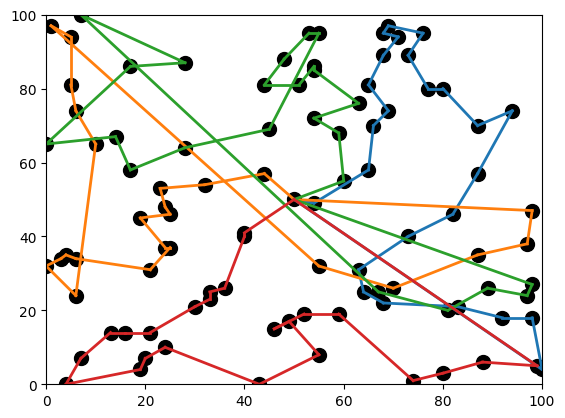

End solution :
  Max weights: 367
  Min weights: 265
  Sum weights: 1245
  Difference max-min: 102


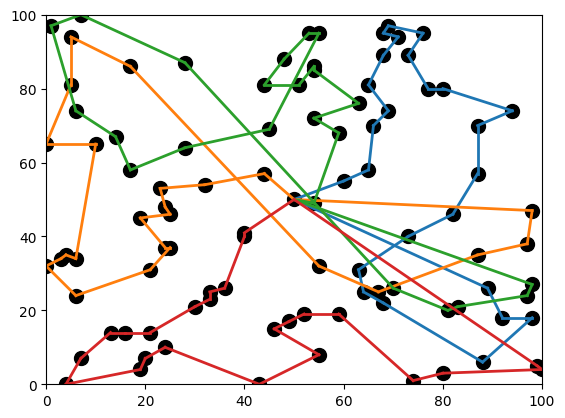

Parameters :
  Num_generations = 500
  population_size = 750
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


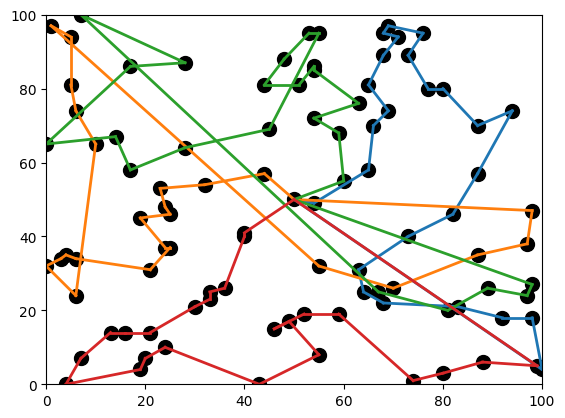

End solution :
  Max weights: 368
  Min weights: 264
  Sum weights: 1223
  Difference max-min: 104


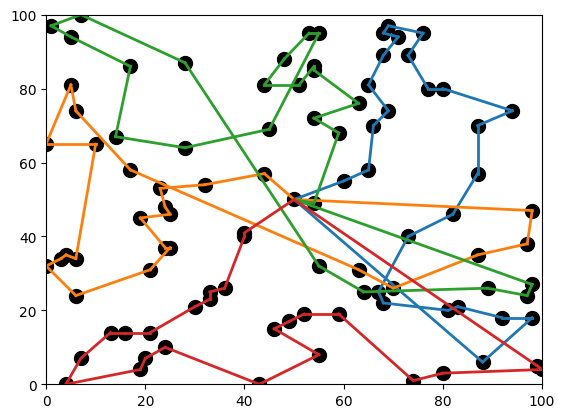

Parameters :
  Num_generations = 500
  population_size = 1000
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


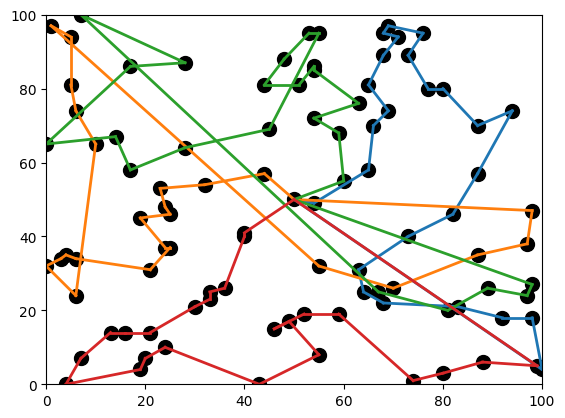

End solution :
  Max weights: 338
  Min weights: 248
  Sum weights: 1186
  Difference max-min: 90


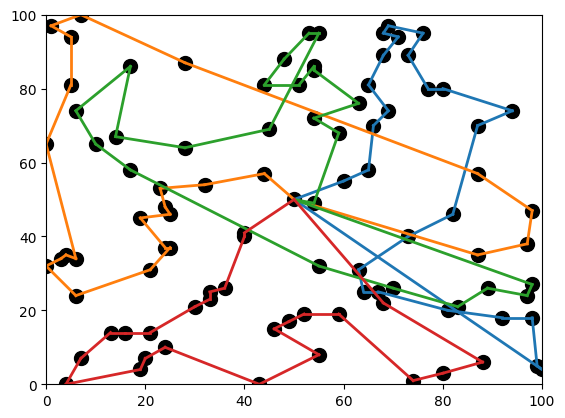

Parameters :
  Num_generations = 750
  population_size = 500
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


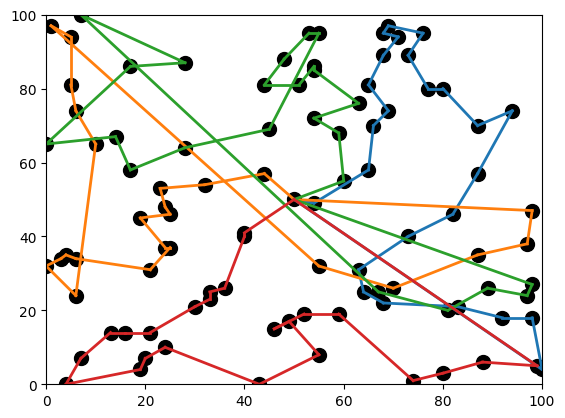

End solution :
  Max weights: 343
  Min weights: 266
  Sum weights: 1183
  Difference max-min: 77


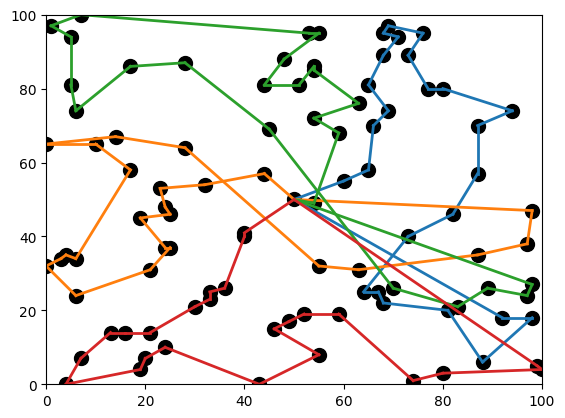

Parameters :
  Num_generations = 750
  population_size = 750
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


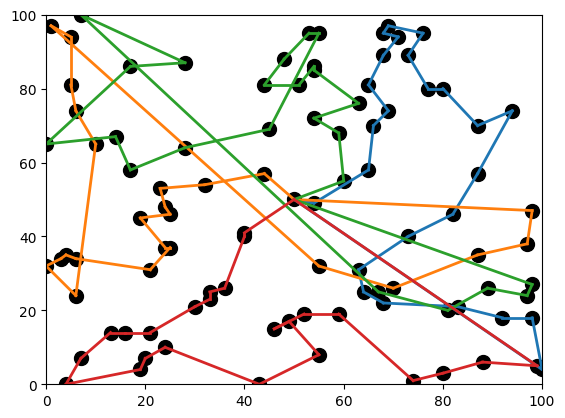

End solution :
  Max weights: 370
  Min weights: 248
  Sum weights: 1218
  Difference max-min: 122


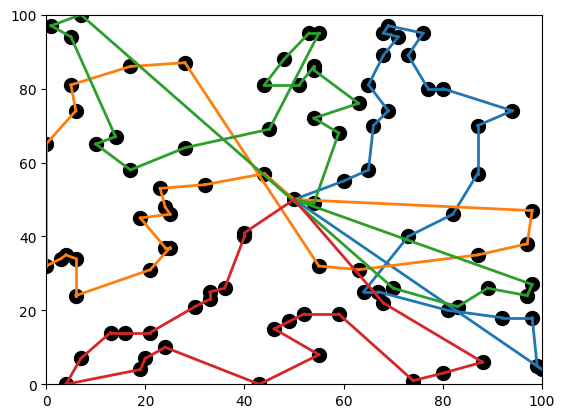

Parameters :
  Num_generations = 750
  population_size = 1000
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


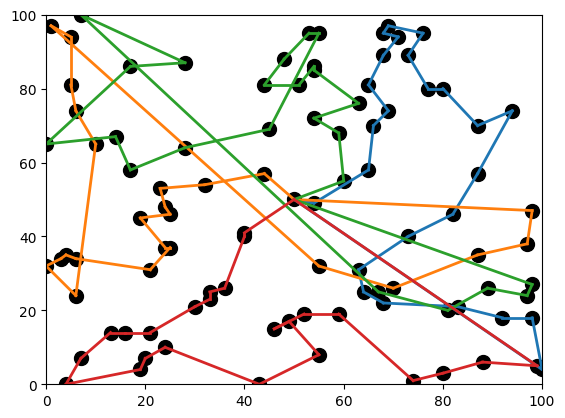

End solution :
  Max weights: 394
  Min weights: 229
  Sum weights: 1229
  Difference max-min: 165


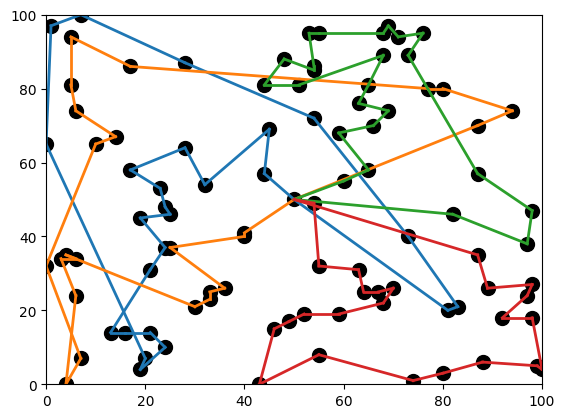

Parameters :
  Num_generations = 1000
  population_size = 500
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


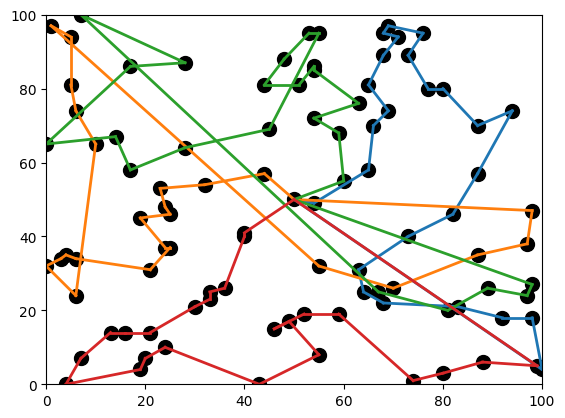

End solution :
  Max weights: 348
  Min weights: 248
  Sum weights: 1200
  Difference max-min: 100


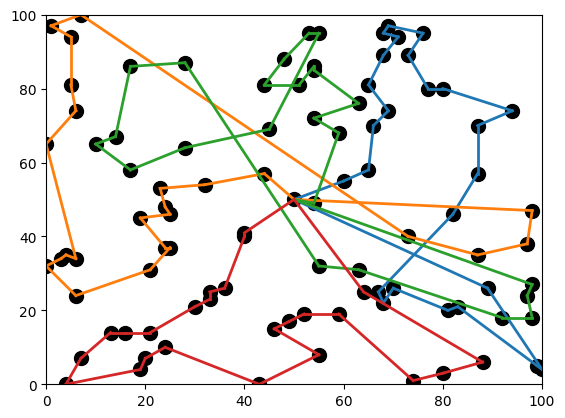

Parameters :
  Num_generations = 1000
  population_size = 750
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


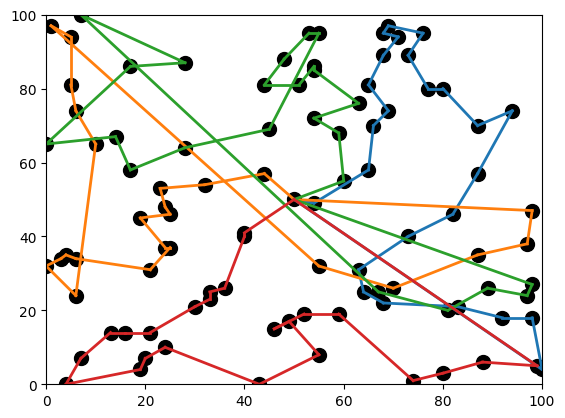

End solution :
  Max weights: 364
  Min weights: 267
  Sum weights: 1209
  Difference max-min: 97


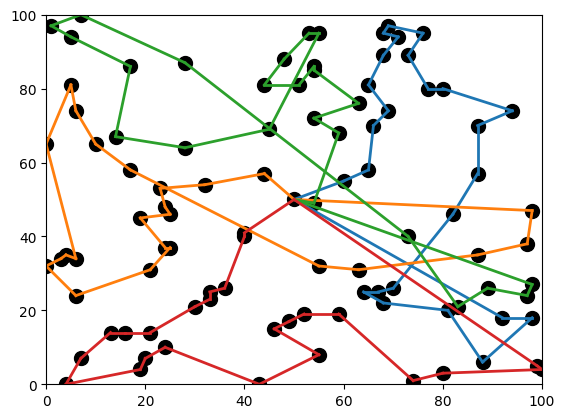

Parameters :
  Num_generations = 1000
  population_size = 1000
  Mutation_rate = 0.1
Best basic solution:
  Max weights: 407
  Min weights: 270
  Sum weights: 1310
  Difference max-min: 137


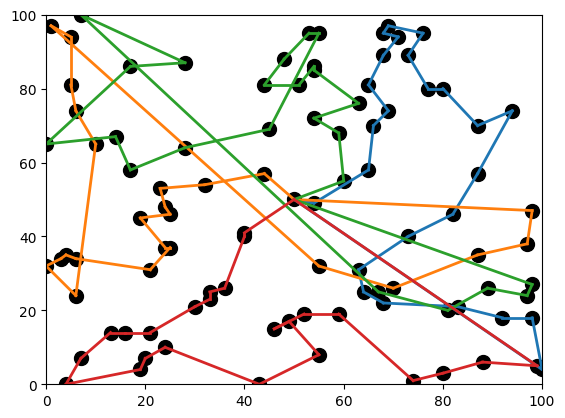

End solution :
  Max weights: 369
  Min weights: 266
  Sum weights: 1236
  Difference max-min: 103


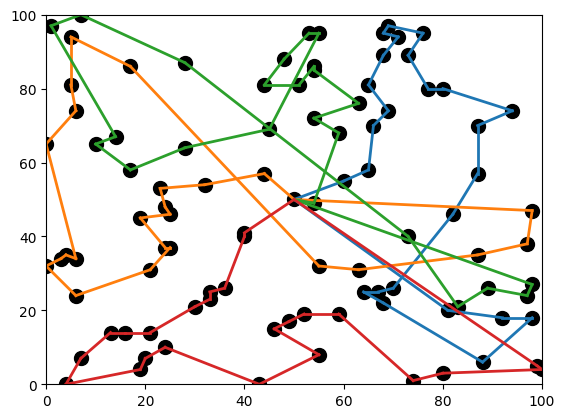

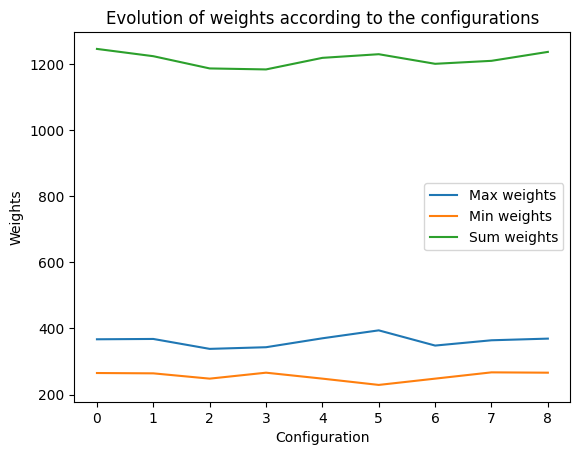

In [22]:
#model parameters
nbrTrucks = 4
num_cities = 99 # must be greater than 2*nbrTrucks+1

# population_size = 100
# num_generations = 1000
# taux_mutations = 0.5

# Checking Constraints
if num_cities < 2* + 1:
    raise ValueError("The number of cities must be greater than or equal to 2k+1.")
else :
    city_distances, matrix, coord_cities = generate_city_distances(num_cities)

num_generations_values =[500,750,1000]
population_size_values = [500,750,1000]
mutations_rate_values = [0.1]


max_weights = []
min_weights = []
sum_weights = []
dif_weights = []

for num_generations in num_generations_values:
    for population_size in population_size_values:
        for mutation_rate in mutations_rate_values:
            print("Parameters :")
            print("  Num_generations =", num_generations)
            print("  population_size =", population_size)
            print("  Mutation_rate =", mutation_rate)

            best_solution, best_solution_base = tsp_genetic_algorithm(city_distances, population_size, num_generations, nbrTrucks, mutation_rate)
            draw_city_graph(coord_cities, best_solution_base)
            total_weights = []
            for route in best_solution:
                total_weight = 0
                for i in range(len(route) - 1):
                    city1 = route[i]
                    city2 = route[i + 1]
                    total_weight += city_distances[city1][city2]
                total_weights.append(total_weight)

            max_weights.append(max(total_weights))
            min_weights.append(min(total_weights))
            sum_weights.append(sum(total_weights))
            dif_weights.append(max(total_weights) - min(total_weights))
            
            print("End solution :")
            print("  Max weights:", max(total_weights))
            print("  Min weights:", min(total_weights))
            print("  Sum weights:", sum(total_weights))
            print("  Difference max-min:", max(total_weights) - min(total_weights))
            draw_city_graph(coord_cities, best_solution)
            

# Creation of the graph
fig, ax = plt.subplots()
ax.plot(max_weights, label="Max weights")
ax.plot(min_weights, label="Min weights")
ax.plot(sum_weights, label="Sum weights")

ax.set_xlabel("Configuration")
ax.set_ylabel("Weights")
ax.set_title("Evolution of weights according to the configurations")
ax.legend()

plt.show()